In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Dataset source: https://www.kaggle.com/datasets/mikhailma/house-rooms-streets-image-dataset

In [2]:
import glob as gb

import cv2
import matplotlib.pylab as plt

plt.style.use('ggplot')

In [3]:
import warnings

warnings.filterwarnings("ignore", message="All log messages before absl::InitializeLog() is called are written to STDERR")
warnings.filterwarnings("ignore", message="Fallback to op-by-op mode because memset node breaks graph update")

In [4]:
from sklearn.model_selection import train_test_split
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

2024-06-13 11:45:19.732516: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 11:45:19.732569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 11:45:19.734253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    
set_random_seed(42)

In [6]:
# Path gambar
img_path = "/kaggle/input/house-rooms-streets-image-dataset/kaggle_room_street_data/house_data"

input_dir = 'images'
output_dir = 'output'

# Membuat folder output jika belum ada
os.makedirs(output_dir, exist_ok=True)

In [7]:
# Membuat Folder Kategori
categories = ['bath', 'bed', 'din', 'kitchen', 'living']
for category in categories:
    category_dir = os.path.join(output_dir, category)
    os.makedirs(category_dir, exist_ok=True)

In [8]:
# Mencari Path Gambar
all_images = gb.glob(img_path + "/*.jpg")

In [9]:
# Memindahkan Gambar ke Folder Kategori yang Sesuai
for img_path in all_images:
    for category in categories:
        if category in img_path:
            shutil.copy(img_path, os.path.join(output_dir, category, os.path.basename(img_path)))
            break # Pindah ke gambar berikutnya setelah menemukan kategori

In [10]:
# Buat folder train dan test
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split data menjadi 70%train 30%test
for category in categories:
    category_dir = os.path.join(output_dir, category)
    images = os.listdir(category_dir)
    train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)
    
    # Pindahkan gambar-gambar ke dalam folder train dan test
    for img in train_images:
        target_dir = os.path.join(train_dir, category)
        os.makedirs(target_dir, exist_ok=True)
        shutil.move(os.path.join(category_dir, img), os.path.join(target_dir, img))

    for img in test_images:
        target_dir = os.path.join(test_dir, category)
        os.makedirs(target_dir, exist_ok=True)
        shutil.move(os.path.join(category_dir, img), os.path.join(target_dir, img))

In [11]:
# Cetak jumlah gambar dalam folder train
print("\nJumlah Gambar dalam Folder Train:")
for category in categories:
    train_category_dir = os.path.join(train_dir, category)
    num_train_images = len(os.listdir(train_category_dir))
    print(f"{category}: {num_train_images} gambar")

# Cetak jumlah gambar dalam folder test
print("\nJumlah Gambar dalam Folder Test:")
for category in categories:
    test_category_dir = os.path.join(test_dir, category)
    num_test_images = len(os.listdir(test_category_dir))
    print(f"{category}: {num_test_images} gambar")


Jumlah Gambar dalam Folder Train:
bath: 423 gambar
bed: 873 gambar
din: 810 gambar
kitchen: 675 gambar
living: 891 gambar

Jumlah Gambar dalam Folder Test:
bath: 182 gambar
bed: 375 gambar
din: 348 gambar
kitchen: 290 gambar
living: 382 gambar


In [12]:
def convert_to_grayscale(img):
    # Konversi gambar ke grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray

In [13]:
def apply_clahe(gray_img):
    # Terapkan CLAHE pada gambar grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray_img)
    
    # Gabungkan kembali ke tiga saluran RGB
    final_img = cv2.merge((clahe_img, clahe_img, clahe_img))
    return final_img

In [14]:
from keras.preprocessing import image

def preprocess_with_clahe(img):
    # Konversi gambar ke array dengan tipe data uint8
    img_array = image.img_to_array(img, dtype='uint8')
    # Konversi gambar ke grayscale
    gray_img = convert_to_grayscale(img_array)
    # Terapkan CLAHE pada gambar grayscale
    img_clahe = apply_clahe(gray_img)
    # Lakukan preprocess_input VGG16
    img_preprocessed = preprocess_input(img_clahe)
    return img_preprocessed

Train Folder

Contoh Gambar untuk Kategori bed:


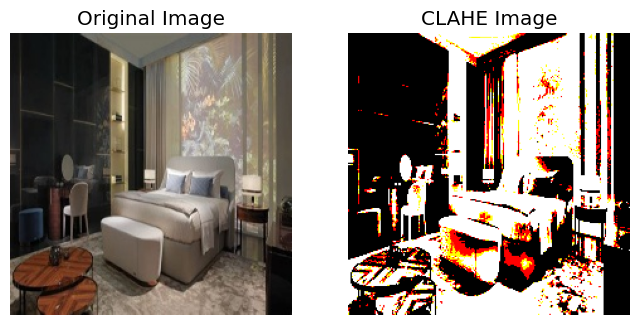


Contoh Gambar untuk Kategori bath:


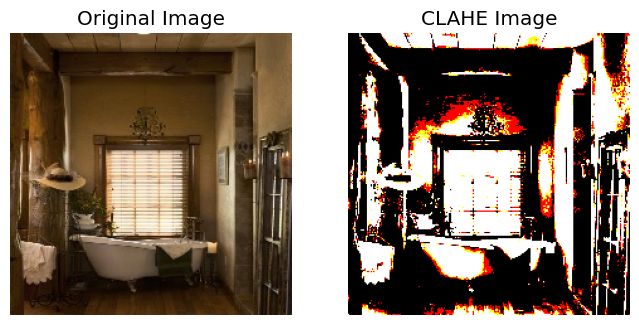


Contoh Gambar untuk Kategori kitchen:


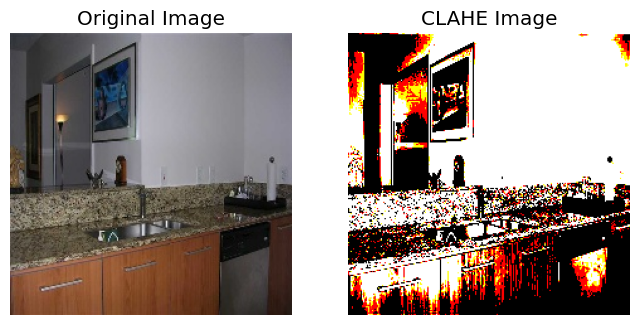


Contoh Gambar untuk Kategori din:


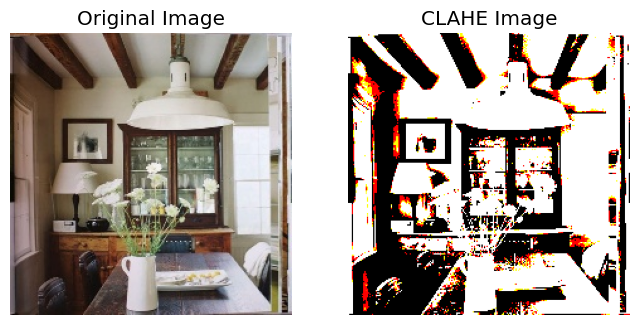


Contoh Gambar untuk Kategori living:


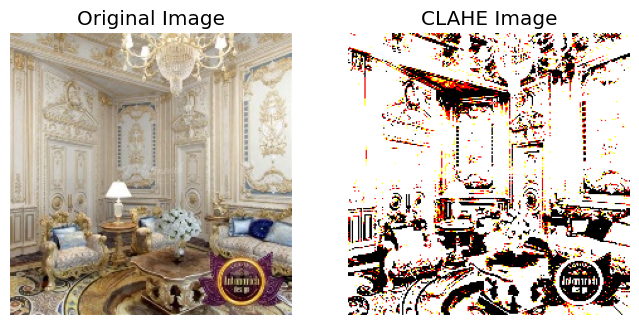


Test Folder

Contoh Gambar untuk Kategori bed:


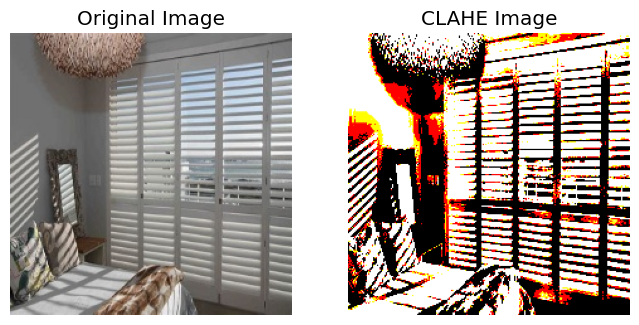


Contoh Gambar untuk Kategori bath:


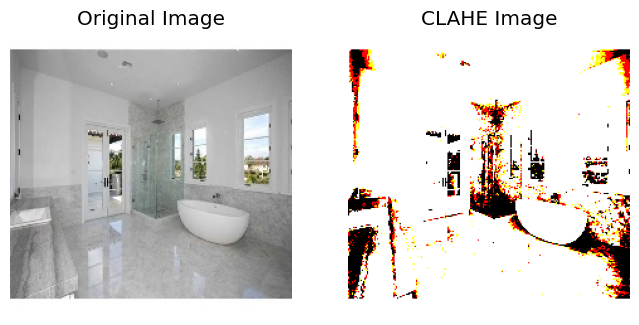


Contoh Gambar untuk Kategori kitchen:


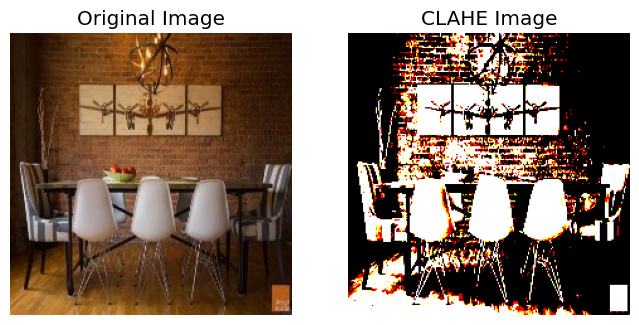


Contoh Gambar untuk Kategori din:


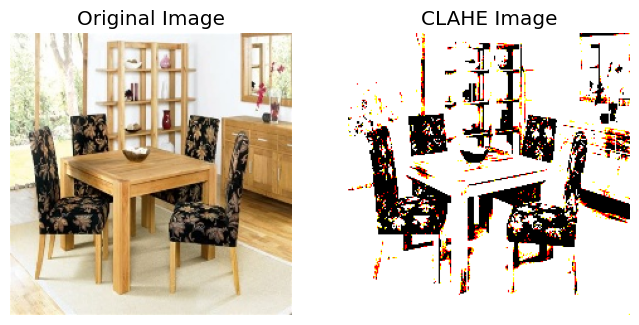


Contoh Gambar untuk Kategori living:


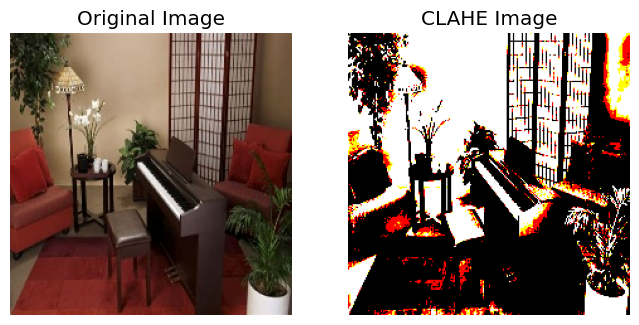

In [15]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.vgg16 import preprocess_input

def visualize_random_images(folder, num_images=1, figsize=(8, 4)):
    categories = os.listdir(folder)
    for category in categories:
        category_dir = os.path.join(folder, category)
        images = os.listdir(category_dir)
        random_images = random.sample(images, num_images)
        print(f"\nContoh Gambar untuk Kategori {category}:")
        for img_file in random_images:
            img_path = os.path.join(category_dir, img_file)
            img = mpimg.imread(img_path)
            img_clahe = preprocess_with_clahe(img)
            
            fig, axes = plt.subplots(1, 2, figsize=figsize)
            axes[0].imshow(img)
            axes[0].set_title('Original Image')
            axes[0].axis("off")
            
            axes[1].imshow(img_clahe)
            axes[1].set_title('CLAHE Image')
            axes[1].axis("off")
            
            plt.show()

print('Train Folder')
visualize_random_images(train_dir, figsize=(8, 4))
print('\nTest Folder')
visualize_random_images(test_dir, figsize=(8, 4))

In [16]:
# Membuat objek ImageDataGenerator untuk pelatihan dengan preprocessing CLAHE
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_with_clahe,
    samplewise_center=True,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

traindata = train_datagen.flow_from_directory(
    directory="./output/train", 
    target_size=(224,224), 
    color_mode="rgb", 
    class_mode='categorical',
    shuffle=False)

# Membuat objek ImageDataGenerator untuk pengujian dengan preprocessing CLAHE
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_with_clahe,
    samplewise_center=True
)

testdata = test_datagen.flow_from_directory(
    directory="./output/test", 
    target_size=(224,224), 
    color_mode="rgb", 
    class_mode='categorical',
    shuffle=False)

Found 3672 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.


In [17]:
# # Membuat objek ImageDataGenerator untuk pelatihan dengan preprocessing CLAHE
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     preprocessing_function=preprocess_with_clahe,
#     samplewise_center=True,
#     rotation_range=10,
#     zoom_range=0.1,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     brightness_range=[0.8, 1.2],
#     horizontal_flip=True,
#     vertical_flip=False,
#     fill_mode='nearest'
# )

# traindata = train_datagen.flow_from_directory(
#     directory="./output/train", 
#     target_size=(224,224), 
#     color_mode="rgb", 
#     class_mode='categorical',
#     shuffle=False)

# # Membuat objek ImageDataGenerator untuk pengujian dengan preprocessing CLAHE
# test_datagen = ImageDataGenerator(
#     rescale=1./255,
#     preprocessing_function=preprocess_with_clahe,
#     samplewise_center=True
# )

# testdata = test_datagen.flow_from_directory(
#     directory="./output/test", 
#     target_size=(224,224), 
#     color_mode="rgb", 
#     class_mode='categorical',
#     shuffle=False)

In [18]:
testdata.class_indices

{'bath': 0, 'bed': 1, 'din': 2, 'kitchen': 3, 'living': 4}

### MODELING

In [19]:
# VGG16 model (VGG16 is a famous convolution neural net (CNN) architecture 
# invented by Karen Simonyan and Andrew Zisserman in 2014.)

from keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# freeze semua layer kecuali 2,3,4 layer dari akhir
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [21]:
# base_model.trainable = False

In [22]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.regularizers import l2
import tensorflow as tf

# model = Sequential()
# model.add(Input(shape=(224, 224, 3)))
# model.add(base_model)
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(GlobalAveragePooling2D())

# # Adding additional Dense layers with Batch Normalization
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(len(categories), activation='softmax'))

model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(base_model)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(len(categories), activation='softmax', kernel_regularizer=l2(0.01)))



# model = Sequential()
# model.add(Input(shape=(224, 224, 3)))
# model.add(base_model)
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(len(categories), activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,239,365 (65.76 MB)

 Trainable params: 9,604,101 (36.64 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [23]:
from tensorflow.keras.optimizers import SGD  # Import SGD optimizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

#maxpooling 2x2 86.30310893058777%
#maxpooling 3x3 85.60557961463928%
#avgpooling 2x2 85.54216623306274%
#avgpooling 3x3 82.81547427177429%

#maxpool 2x2 + grayscale clahe  87.38110065460205%

device_name = tf.test.gpu_device_name()

np.random.seed(42)

modelpath = './output/bestmodel.keras'

### train the model
with tf.device(device_name):
    
    optimizer = SGD(learning_rate=0.005)
    
    model.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',
      metrics=['accuracy'])

    # Early stopping for val_accuracy
    early_stopping_acc = EarlyStopping(monitor='val_accuracy', patience=10, 
                                       restore_best_weights=True, mode='max')

    # Early stopping for val_loss
    early_stopping_loss = EarlyStopping(monitor='val_loss', patience=5, 
                                        restore_best_weights=True, mode='min')

    
    # Reduce learning rate when a metric has stopped improving
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, 
                                  patience=8, min_lr=0.000005, verbose=1)

    
    # Callback ModelCheckpoint untuk menyimpan bobot terbaik
    checkpoint = ModelCheckpoint(
        modelpath,
        monitor='val_accuracy',
        save_best_only=True,  # Hanya menyimpan bobot terbaik
        mode='max',  # Mode untuk membandingkan nilai metrik (misalnya 'max' untuk akurasi)
        verbose=1  # Menampilkan pesan saat menyimpan
    )

    # Train the model
    history = model.fit(x=traindata, validation_data=testdata, epochs=200, 
                        batch_size=32, callbacks=[early_stopping_acc, early_stopping_loss,
                                                  checkpoint,reduce_lr])

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/115 ━━━━━━━━━━━━━━━━━━━━ 1:24:18 44s/step - accuracy: 0.0312 - loss: 16.6454

I0000 00:00:1718279185.282571    1049 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718279185.302328    1049 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 25/115 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.2113 - loss: 16.3194  

W0000 00:00:1718279225.796013    1050 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.2368 - loss: 16.0905

W0000 00:00:1718279259.836690    1050 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718279277.959754    1050 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.42295, saving model to ./output/bestmodel.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 137s 816ms/step - accuracy: 0.2369 - loss: 16.0889 - val_accuracy: 0.4230 - val_loss: 15.5661 - learning_rate: 0.0050
Epoch 2/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.2755 - loss: 15.5468
Epoch 2: val_accuracy improved from 0.42295 to 0.42866, saving model to ./output/bestmodel.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 60s 444ms/step - accuracy: 0.2760 - loss: 15.5457 - val_accuracy: 0.4287 - val_loss: 15.0616 - learning_rate: 0.0050
Epoch 3/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.4380 - loss: 15.0219
Epoch 3: val_accuracy improved from 0.42866 to 0.62080, saving model to ./output/bestmodel.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 53s 434ms/step - accuracy: 0.4381 - loss: 15.0211 - val_accuracy: 0.6208 - val_loss: 14.5053 - learning_rate: 0.0050
Epoch 4/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5005 - loss: 14.5739
Ep

In [24]:
#Test the model with the test set

model.evaluate(testdata)

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9057 - loss: 4.2458


[4.377779006958008, 0.8750792741775513]

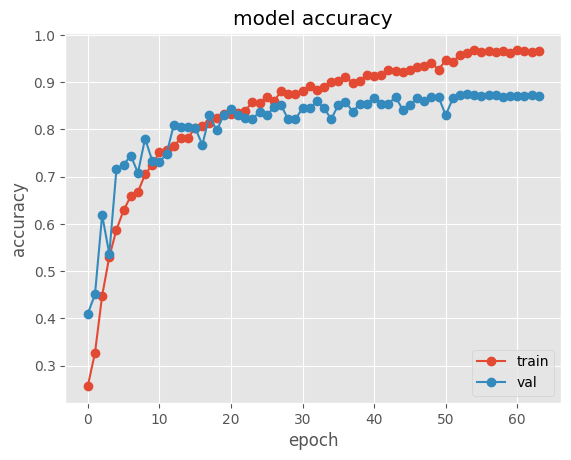

In [25]:
# Visualize the model

plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

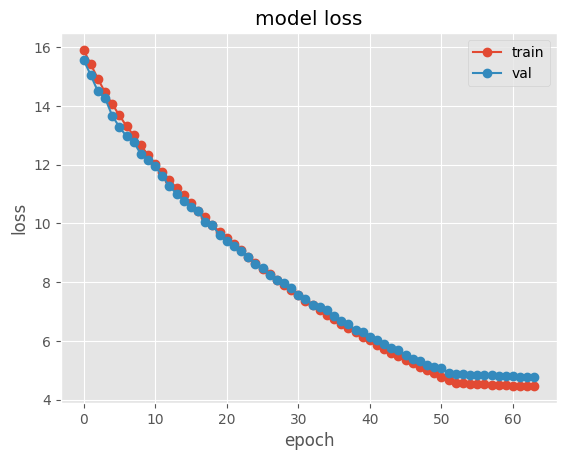

In [26]:
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [27]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Prediksi label kelas menggunakan model terhadap data uji
predictions = model.predict(testdata)
predicted_classes = np.argmax(predictions, axis=1)

# Ambil label sebenarnya dari data uji
true_classes = testdata.labels

# Dapatkan nama kelas
class_labels = list(testdata.class_indices.keys())

# Buat classification matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print classification matrix
print("Classification Matrix:")
print(cm)

# Print classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

 2/50 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step 

W0000 00:00:1718278975.367635     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step
Classification Matrix:
[[169   3   1   5   4]
 [  4 338   3   3  27]
 [  4   1 309  18  16]
 [ 11   1  35 232  11]
 [  3  18  26   9 326]]

Classification Report:
              precision    recall  f1-score   support

        bath       0.88      0.93      0.91       182
         bed       0.94      0.90      0.92       375
         din       0.83      0.89      0.86       348
     kitchen       0.87      0.80      0.83       290
      living       0.85      0.85      0.85       382

    accuracy                           0.87      1577
   macro avg       0.87      0.87      0.87      1577
weighted avg       0.87      0.87      0.87      1577



W0000 00:00:1718278982.462967     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy adalah rasio dari jumlah prediksi yang benar (true predictions) dibagi dengan jumlah total instance dalam dataset. 

Precision mengukur seberapa akurat model dalam memprediksi kelas positif. Ini dihitung sebagai rasio dari true positive (TP) dibagi oleh jumlah true positive dan false positive (FP). 

 Recall mengukur seberapa baik model dalam menemukan semua instance yang benar dari kelas yang diinginkan. Ini dihitung sebagai rasio dari true positive (TP) dibagi oleh jumlah true positive dan false negative (FN). 

F1-score adalah rata-rata harmonik dari precision dan recall. Ini memberikan keseimbangan antara precision dan recall.

### Mencoba dengan dataset lain

### Dataset source: https://www.kaggle.com/datasets/annielu21/house-rooms

In [ ]:
import os
import shutil

# Menggunakan direktori yang dapat ditulis
img_path2 = '/kaggle/input/house-rooms/room-dataset'
input_dir = 'images'
output_dir2 = 'new_output'

# Membuat folder output jika belum ada
os.makedirs(output_dir2, exist_ok=True)

# Membuat Folder Kategori
categories = ['bath', 'bed', 'din', 'kitchen', 'living']
for category in categories:
    category_dir = os.path.join(output_dir2, category)
    os.makedirs(category_dir, exist_ok=True)

In [ ]:
folder_mapping = {
    'bathroom': 'bath',
    'bedroom': 'bed',
    'dining': 'din',
    'kitchen': 'kitchen',
    'living': 'living'
}

In [ ]:
# Memindahkan file ke folder yang dipilih
for root, dirs, files in os.walk(img_path2):
    for file in files:
        category = os.path.basename(root)
        if category in folder_mapping:
            source_file = os.path.join(root, file)
            destination_dir = os.path.join(output_dir2, folder_mapping[category])
            shutil.copy(source_file, destination_dir)

In [ ]:
for category in categories:
    category_dir = os.path.join(output_dir2, category)
    num_files = len(os.listdir(category_dir))
    print(f"Total {category} files: {num_files}")

In [ ]:
# Define the ImageDataGenerator for the new dataset
new_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

# Create a generator for the new dataset
new_generator = new_datagen.flow_from_directory(
    directory=output_dir2,
    classes=['bath', 'bed', 'din', 'kitchen', 'living'],
    target_size=(224,224), 
    color_mode="rgb", 
    class_mode='categorical',
    batch_size=32,  # Specify the batch size
    shuffle=False  # Do not shuffle the data for testing
)

In [ ]:
def create_model():

    np.random.seed(42)

    model = Sequential()
    model.add(Input(shape=(224,224,3)))
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(categories), activation='softmax'))
    
    
    optimizer = SGD(learning_rate=0.005)
    
    model.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',
      metrics=['accuracy'])
    
    return model

model2 = create_model()

In [ ]:
model2.summary()

In [ ]:
model2.load_weights('/kaggle/working/output/bestmodel.keras')

In [ ]:
model2.evaluate(new_generator)

### Didapatkan akurasi 80% untuk dataset yang lain